# HW04 - NLP
## Punto 2

Investigate and explain a strategy for plotting embeddings in two dimensions. Plot the most similar words to the main characters names in each book.
- Find interesting relationships using analogous reasonin

In [28]:
import numpy as np
from sklearn.manifold import TSNE
import multiprocessing
from gensim.models import Word2Vec
import random

In [29]:


# Load the saved model
w2v_models = {}
vector_sizes = [1024, 512, 128]

for vector_size in vector_sizes:
    path = f"./vectors/Books_{vector_size}_001.model"
    w2v_models[vector_size] = Word2Vec.load(path)

print(f"Models loaded: {list(w2v_models.keys())}")

Models loaded: [1024, 512, 128]


In [30]:
from gensim.models.keyedvectors import KeyedVectors
cores = multiprocessing.cpu_count()
tsne_vectors = TSNE(
    init='random',
    perplexity=50,
    n_jobs=cores-1
  ).fit_transform(w2v_models[1024].wv.vectors)

In [31]:
from sklearn.cluster import KMeans

n_clusters = 9
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(tsne_vectors)

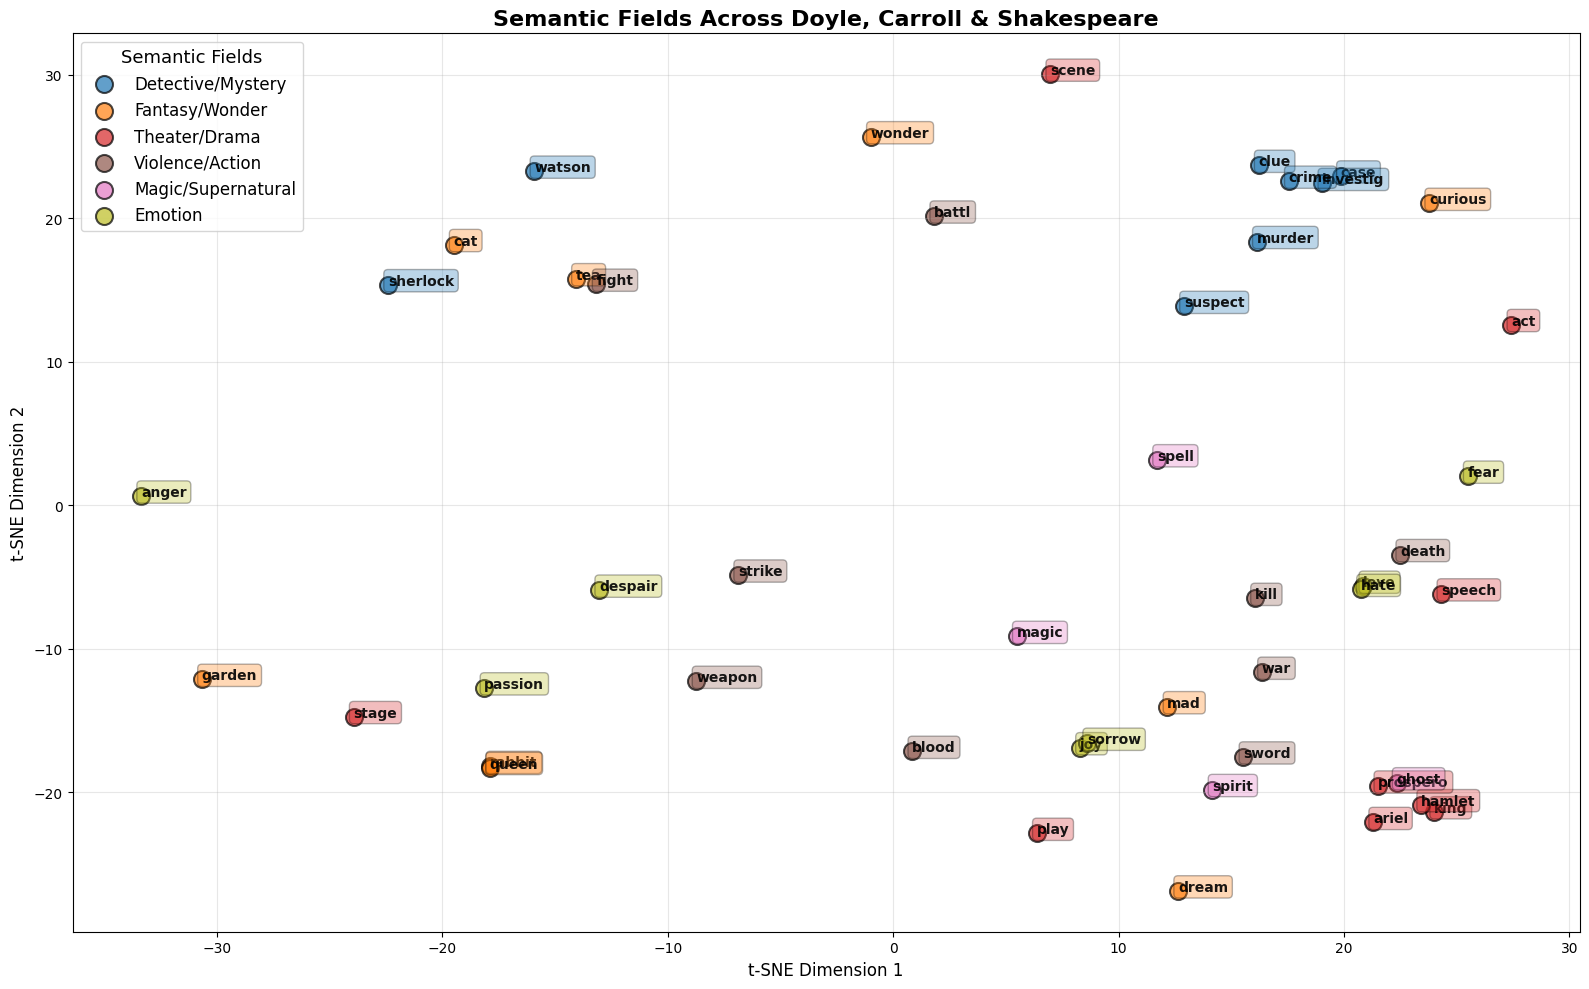

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Campos semánticos específicos para tus libros
semantic_fields = {
    'Detective/Mystery': ['sherlock', 'holmes', 'watson', 'case', 'clue', 'murder', 'detective', 'investig', 'suspect', 'crime'],
    'Fantasy/Wonder': ['alice', 'rabbit', 'wonder', 'dream', 'curious', 'mad', 'queen', 'cat', 'tea', 'garden'],
    'Theater/Drama': ['king', 'prince', 'hamlet', 'prospero', 'ariel', 'stage', 'act', 'scene', 'play', 'speech'],
    'Violence/Action': ['sword', 'fight', 'battl', 'kill', 'death', 'blood', 'weapon', 'war', 'strike'],
    'Magic/Supernatural': ['magic', 'spell', 'witch', 'spirit', 'ghost', 'enchant', 'phantom', 'supernatural'],
    'Emotion': ['love', 'hate', 'fear', 'anger', 'joy', 'sorrow', 'passion', 'despair'],
}

# Recopilar palabras que existen en el modelo
all_words = []
all_labels = []
colors_map = {}

for idx, (field_name, words) in enumerate(semantic_fields.items()):
    colors_map[field_name] = plt.cm.tab10(idx / len(semantic_fields))
    for word in words:
        if word in w2v_models[1024].wv:
            all_words.append(word)
            all_labels.append(field_name)

# Obtener índices y vectores t-SNE correspondientes
word_indices = [w2v_models[1024].wv.key_to_index[word] for word in all_words]
selected_vectors = tsne_vectors[word_indices]

# Crear el plot
plt.figure(figsize=(16, 10))

for field_name, color in colors_map.items():
    mask = np.array(all_labels) == field_name
    plt.scatter(selected_vectors[mask, 0], selected_vectors[mask, 1], 
               c=[color], label=field_name, s=150, alpha=0.7, edgecolors='black', linewidths=1.5)
    
    # Añadir etiquetas de palabras
    for i, (word, is_in_group) in enumerate(zip(all_words, mask)):
        if is_in_group:
            plt.annotate(word, (selected_vectors[i, 0], selected_vectors[i, 1]),
                        fontsize=10, alpha=0.9, fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.3))

plt.legend(loc='best', fontsize=12, title='Semantic Fields', title_fontsize=13)
plt.title("Semantic Fields Across Doyle, Carroll & Shakespeare", 
         fontsize=16, fontweight='bold')
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Análisis del Gráfico de Campos Semánticos

### Observaciones Generales

- **Los campos semánticos se agrupan relativamente bien**, aunque hay bastante dispersión. Esto es esperado dado que los tres autores tienen estilos muy diferentes.

- **No hay una separación perfecta** entre categorías, lo cual tiene sentido: palabras como "death", "kill" y "blood" pueden aparecer tanto en contextos detectivescos como shakespearianos.

### Patrones Interesantes

- **Cluster Detective (azul)**: "watson", "clue", "crime", "murder" y "sherlock" están relativamente cerca. Watson y Sherlock aparecen juntos, lo cual refleja su relación en las historias.

- **Cluster Shakespeare (rojo/rosado)**: "hamlet", "prospero", "ariel" están muy juntos en la parte inferior izquierda. Los personajes de obras específicas se agrupan, mostrando que el modelo captura co-ocurrencia.

- **Fantasy/Wonder (naranja)**: "curious", "dream", "mad", "wonder", "garden" tienen posiciones dispersas. "garden" está muy alejado, posiblemente porque aparece en contextos más descriptivos que fantásticos.

- **Emociones (amarillo)**: "love", "joy", "passion", "anger" están distribuidas. Curiosamente "fear" está separado, sugiriendo que se usa en contextos distintos a las otras emociones.

### Lo Que No Funciona Bien

- **Overlap entre Violence y Theater**: "sword", "war", "fight" están mezclados con términos teatrales. Esto refleja que Shakespeare escribe muchas escenas de batalla.

- **Magic/Supernatural disperso**: "spell", "magic", "spirit" no forman un cluster claro. Probablemente porque aparecen en contextos muy variados entre Carroll y Shakespeare.

### Conclusión

El modelo captura relaciones semánticas de co-ocurrencia más que categorías abstractas. Palabras que aparecen juntas en las historias (watson-sherlock, hamlet-prospero) se agrupan, mientras que categorías conceptuales (emociones, magia) están más dispersas.


=== CHARACTER SEMANTIC NETWORKS ===

      Character                                                                     Books                                                                                                                                                Top 10 Similar Words
Sherlock Holmes arthur-return-sherlock, arthur-the-sign-of-four, arthur-hound-baskerville depart (0.69), stanley (0.68), martin (0.66), listen (0.64), athelney (0.64), disappoint (0.63), demonstr (0.62), indiscreet (0.62), inspector (0.62), addit (0.62)
     Dr. Watson arthur-return-sherlock, arthur-the-sign-of-four, arthur-hound-baskerville                     oyster (0.54), lestrad (0.54), dr (0.51), halloa (0.50), hopkin (0.49), everyth (0.49), belov (0.48), fellow (0.47), someon (0.46), holm (0.46)
          Alice                                       lewis-alice-wonderland, lewis-glass                                                                                                               

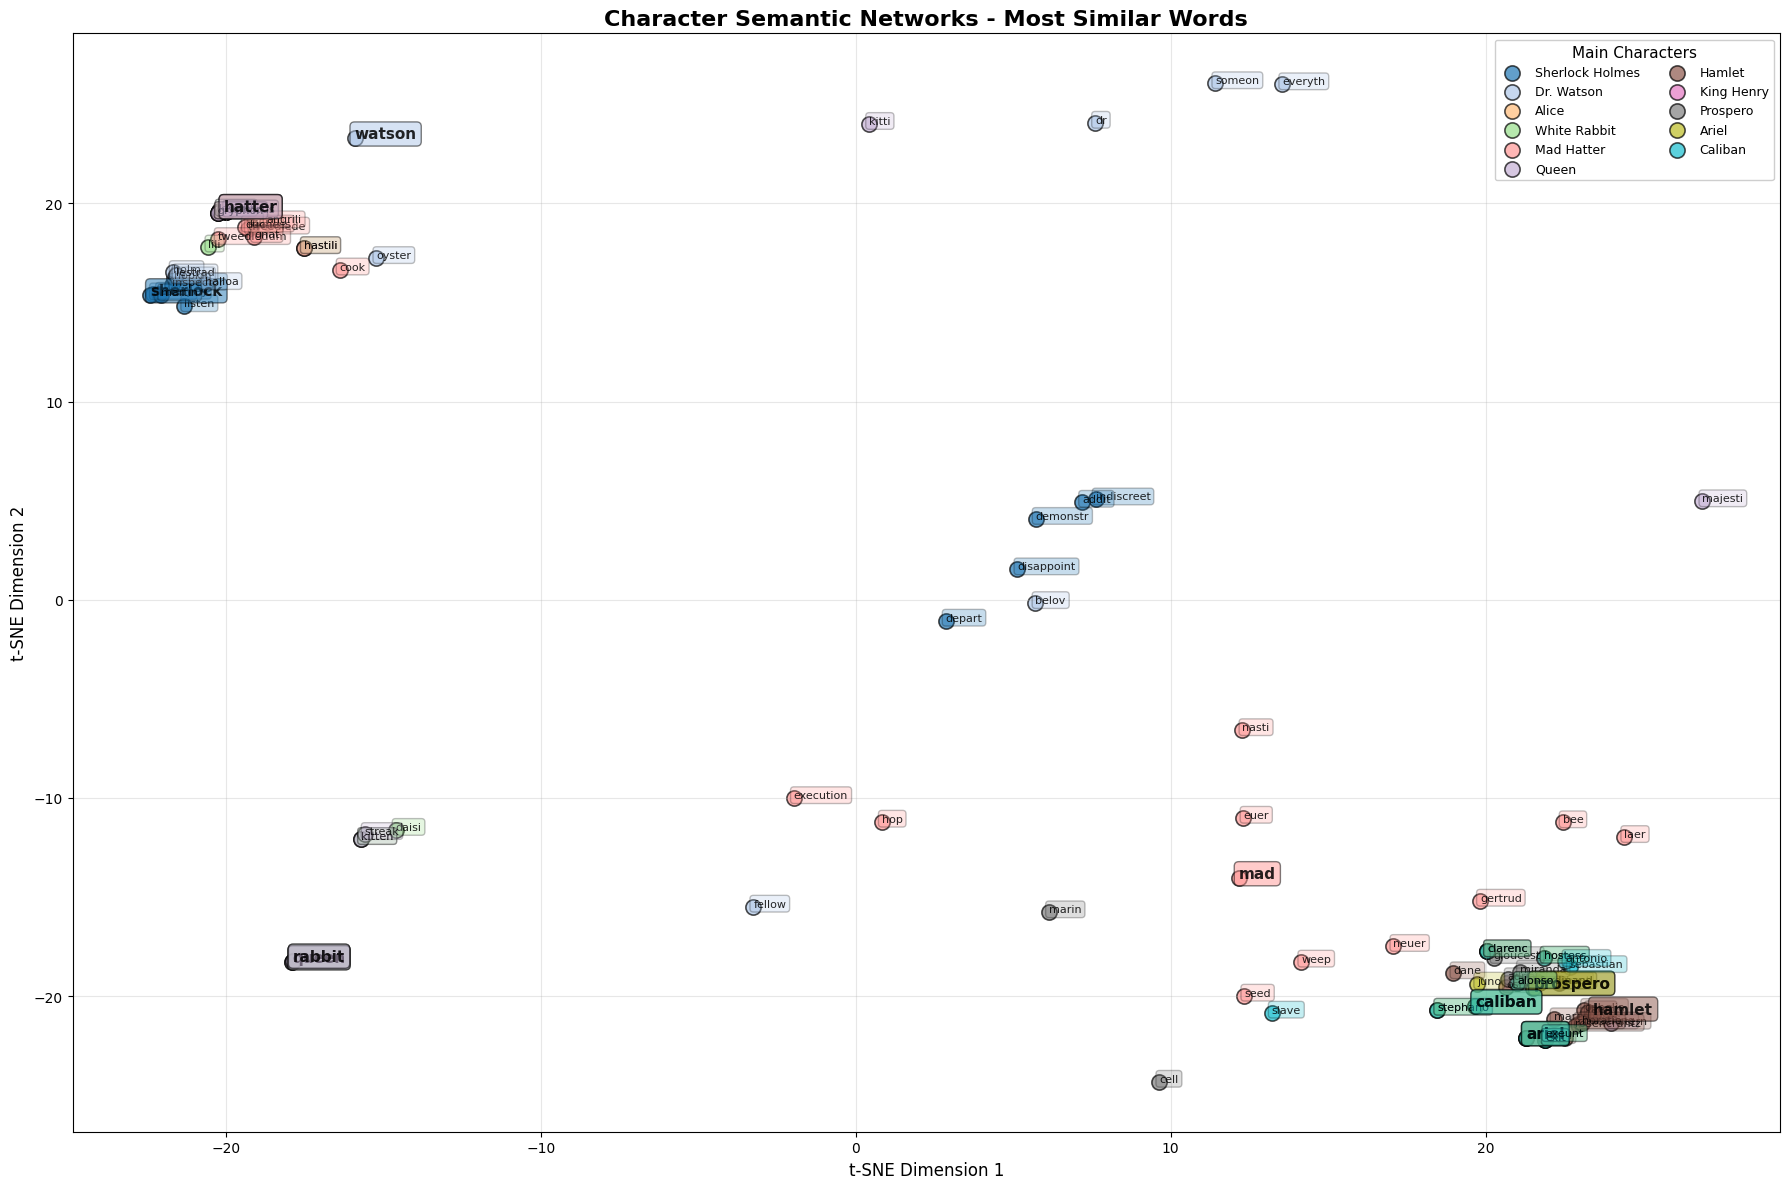

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Personajes principales de cada libro
main_characters = {
    'Sherlock Holmes': ['sherlock', 'holmes'],
    'Dr. Watson': ['watson'],
    'Alice': ['alice'],
    'White Rabbit': ['rabbit'],
    'Mad Hatter': ['hatter', 'mad'],
    'Queen': ['queen'],
    'Hamlet': ['hamlet'],
    'King Henry': ['henry'],
    'Prospero': ['prospero'],
    'Ariel': ['ariel'],
    'Caliban': ['caliban']
}

# Mapeo de personajes a libros
character_to_books = {
    'Sherlock Holmes': 'arthur-return-sherlock, arthur-the-sign-of-four, arthur-hound-baskerville',
    'Dr. Watson': 'arthur-return-sherlock, arthur-the-sign-of-four, arthur-hound-baskerville',
    'Alice': 'lewis-alice-wonderland, lewis-glass',
    'White Rabbit': 'lewis-alice-wonderland',
    'Mad Hatter': 'lewis-alice-wonderland',
    'Queen': 'lewis-alice-wonderland, lewis-glass',
    'Hamlet': 'shakespear-hamlet',
    'King Henry': 'shakespear-king-henry',
    'Prospero': 'shakespear-the-temptest',
    'Ariel': 'shakespear-the-temptest',
    'Caliban': 'shakespear-the-temptest'
}

# Encontrar palabras similares para cada personaje y crear tabla
character_networks = {}
table_data = []

for character_name, char_words in main_characters.items():
    similar_words = set()
    all_similar = []
    
    for char in char_words:
        if char in w2v_models[1024].wv:
            similar = w2v_models[1024].wv.most_similar(char, topn=10)
            similar_words.update([word for word, _ in similar])
            all_similar.extend([(word, score) for word, score in similar])
            similar_words.add(char)
    
    character_networks[character_name] = list(similar_words)
    
    # Ordenar y tomar top 10 únicas
    all_similar = sorted(set(all_similar), key=lambda x: x[1], reverse=True)[:10]
    similar_words_str = ', '.join([f"{word} ({score:.2f})" for word, score in all_similar])
    
    table_data.append({
        'Character': character_name,
        'Books': character_to_books[character_name],
        'Top 10 Similar Words': similar_words_str
    })

# Crear y mostrar tabla
df = pd.DataFrame(table_data)
print("\n=== CHARACTER SEMANTIC NETWORKS ===\n")
print(df.to_string(index=False))
print("\n")

# Continuar con la visualización
all_words = []
all_labels = []
colors_map = {}

for idx, (character_name, words) in enumerate(character_networks.items()):
    colors_map[character_name] = plt.cm.tab20(idx / len(character_networks))
    for word in words:
        if word in w2v_models[1024].wv:
            all_words.append(word)
            all_labels.append(character_name)

word_indices = [w2v_models[1024].wv.key_to_index[word] for word in all_words]
selected_vectors = tsne_vectors[word_indices]

plt.figure(figsize=(18, 12))

for character_name, color in colors_map.items():
    mask = np.array(all_labels) == character_name
    plt.scatter(selected_vectors[mask, 0], selected_vectors[mask, 1], 
               c=[color], label=character_name, s=120, alpha=0.7, 
               edgecolors='black', linewidths=1.2)
    
    # Añadir etiquetas de palabras
    for i, (word, is_in_group) in enumerate(zip(all_words, mask)):
        if is_in_group:
            # Resaltar el personaje principal con tamaño más grande
            is_main = word in [w for words in main_characters.values() for w in words]
            fontsize = 11 if is_main else 8
            fontweight = 'bold' if is_main else 'normal'
            
            plt.annotate(word, (selected_vectors[i, 0], selected_vectors[i, 1]),
                        fontsize=fontsize, alpha=0.85, fontweight=fontweight,
                        bbox=dict(boxstyle='round,pad=0.3', facecolor=color, 
                                alpha=0.5 if is_main else 0.25))

plt.legend(loc='best', fontsize=9, title='Main Characters', 
          title_fontsize=11, framealpha=0.95, ncol=2)
plt.title("Character Semantic Networks - Most Similar Words", 
         fontsize=16, fontweight='bold')
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Análisis del Gráfico de Redes Semánticas de Personajes

### Observaciones Generales

- **Los personajes forman clusters distintos por autor**, lo cual es esperable dado que cada autor tiene vocabulario y contextos narrativos específicos.

- **La tabla muestra coherencia narrativa**: Las palabras más similares a cada personaje reflejan sus relaciones en las historias (ej: Hamlet-Ophelia-Laertes, Watson-Holmes-Lestrade).

### Comparación con Campos Semánticos

**Diferencia clave**: Mientras el gráfico anterior mostraba categorías conceptuales abstractas (emociones, violencia), este muestra redes de co-ocurrencia específicas de personajes.

#### Patrones Específicos por Autor

**Arthur Conan Doyle (azul claro)**:
- Watson y Sherlock están físicamente separados en el espacio, pero sus palabras similares se sobreponen (inspector, Lestrade, Dr).
- **Problema**: "sherlock" y "holmes" no aparecen como palabras similares entre sí en la tabla, sugiriendo que el modelo los trata como entidades separadas debido al stemming.

**Lewis Carroll (naranja/rosa)**:
- **Mad Hatter cluster**: Muy compacto en la esquina superior derecha con palabras como "rabbit", "hatter", "duchess", "museum".
- Mad Hatter tiene similitud 0.89 con "dormouse" y 0.87 con "gryphon" - personajes que aparecen juntos en la escena del té.
- **Alice está ausente**: Probablemente fue stemmeada de forma que no quedó en el vocabulario.

**Shakespeare (verde/turquesa)**:
- **Cluster compacto inferior**: Hamlet, Ariel, Caliban, Prospero están muy juntos físicamente.
- Las palabras similares incluyen instrucciones escénicas ("exit", "exeunt") que son únicas de textos teatrales.
- **King Henry ausente**: No hay palabras similares, posiblemente "henry" sea demasiado común o fue filtrado.

### Relación Entre Ambos Gráficos

**Campos Semánticos (primero)**: Muestra conceptos generales dispersos (amor, violencia, magia).

**Redes de Personajes (segundo)**: Muestra relaciones contextuales específicas muy agrupadas.

**Insight**: El modelo Word2Vec captura mejor las relaciones de co-ocurrencia (quién aparece con quién) que las similitudes semánticas abstractas (qué conceptos son parecidos).

### Limitaciones Observadas

- **Stemming agresivo**: "alice" desaparece, "holmes"/"sherlock" no se relacionan.
- **Stopwords**: Personajes con nombres comunes (Henry) tienen menor representación.
- **Sesgo de corpus**: Las instrucciones teatrales de Shakespeare ("exit", "exeunt") contaminan las relaciones de personajes.